In [2]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import median, stdev

In [3]:
trans_metrics = ['OT', 'TCA', 'MMD']
score_dir = "/home/wanxinli/EHR-OT/outputs/mimic/"

group_name = 'insurance'
group_1 = 'Medicaid'
group_2 = 'Self_Pay'

# group_name = 'gender'
# group_1 = 'M'
# group_2 = 'F'

# group_name = 'ethnicity'
# group_1 = 'WHITE'
# # group_2 = 'HISPANIC_OR_LATINO'
# group_2 = 'ASIAN'

In [4]:

def ratios_for_metrics(eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [5]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

MAE for OT, Median: 29.6%, Stdev: 8.4%
MAE for TCA, Median: -0.2%, Stdev: 0.8%
MAE for MMD, Median: 16.0%, Stdev: 4.0%


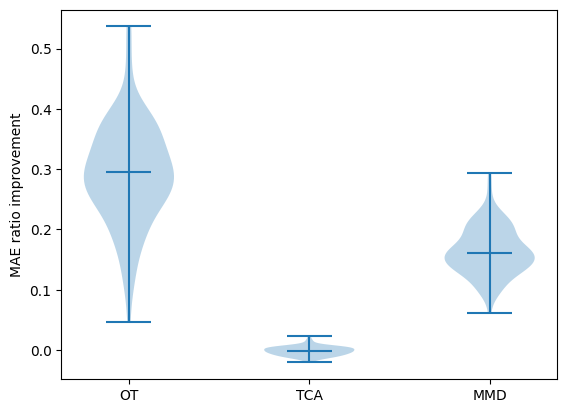

In [6]:
mae_improve_ratios = ratios_for_metrics('mae', trans_metrics)
trans_metrics = ['OT', 'TCA', 'MMD']
print_median_std(mae_improve_ratios, trans_metrics, 'MAE')

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: mae_improve_ratios[0],
    trans_metrics[1]: mae_improve_ratios[1], 
    trans_metrics[2]: mae_improve_ratios[2]
})

# Plot the dataframe
plt.violinplot(data, showmedians=True)
plt.xticks([1, 2, 3], labels=trans_metrics)
plt.ylabel("MAE ratio improvement")
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_MAE.pdf")
plt.savefig(fig_path)
plt.show()



RMSE for OT, Median: 35.1%, Stdev: 9.5%
RMSE for TCA, Median: -0.3%, Stdev: 0.9%
RMSE for MMD, Median: 18.6%, Stdev: 4.9%


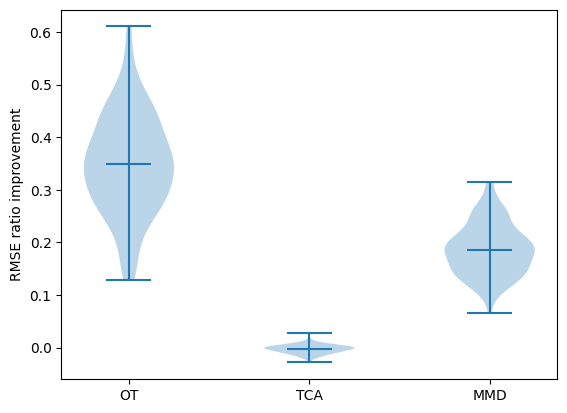

In [7]:
rmse_improve_ratios = ratios_for_metrics('rmse', trans_metrics)
trans_metrics = ['OT', 'TCA', 'MMD']
print_median_std(rmse_improve_ratios, trans_metrics, 'RMSE')

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: rmse_improve_ratios[0],
    trans_metrics[1]: rmse_improve_ratios[1], 
    trans_metrics[2]: rmse_improve_ratios[2]
})

# Plot the dataframe
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2, 3], labels=trans_metrics)
plt.ylabel("RMSE ratio improvement")
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_RMSE.pdf")
plt.savefig(fig_path)
plt.show()



In [10]:
# group_name = 'insurance'
# groups = ['Self_Pay', 'Government', 'Private',  'Medicare', 'Medicaid']

# trans_metrics = ['OT', 'TCA', 'MMD']
group_name = 'marital_status'
groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        print(f"group 1: {group_1}, group_2: {group_2}")
        mae_improve_ratios = ratios_for_metrics('mae', trans_metrics)
        print_median_std(mae_improve_ratios, trans_metrics, 'MAE')
        rmse_improve_ratios = ratios_for_metrics('rmse', trans_metrics)
        print_median_std(rmse_improve_ratios, trans_metrics, 'RMSE')

group 1: DIVORCED, group_2: SEPARATED


FileNotFoundError: [Errno 2] No such file or directory: '/home/wanxinli/EHR-OT/outputs/mimic/exp4_marital_status_SEPARATED2DIVORCED_MMD.csv'